In [1]:
# do pair counting for simno=0, tet=4 and 8
# pair ounting for tet=1 is too slow
# use codes similar to Quijote: MAS, then compute CF
# draw plots showing the improvement of resample/ center resample


In [1]:
from Corrfunc.theory.xi import xi
import numpy as np
import sys
from colossus.cosmology import cosmology
import readgadget
from tetrahedrafunc import *
from time import perf_counter as time
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
oakdir="/oak/stanford/orgs/kipac/users/xinshuo/"
snapdir=oakdir+"QuijoteData/Snapshots/fiducial_ZA/0/"

QuijoteFid = {'H0': 67.11,
 'Ob0': 0.049, 
 'Om0': 0.3175,
 'flat': True,
 'ns': 0.9624,
 'sigma8': 0.834}
mycosmos =  cosmology.setCosmology("QuijoteFid", **QuijoteFid)
nthreads = 32
xshift,yshift,zshift=0,0,0

In [2]:
#read initial
snapno = -1
if snapno == -1 : # ICs
    snapshot = snapdir+"ICs/ics"
    initz=127
else:
    snapshot = snapdir+"snapdir_%03d/snap_%03d"%(snapno,snapno)
    zmap={0:3,1:2,2:1,3:0.5,4:0}
    currentz = zmap[snapno]
ptype    = [1] #[1](CDM), [2](neutrinos) or [1,2](CDM+neutrinos)
print("reading",flush=True)
# read positions, velocities and IDs of the particles
pos = readgadget.read_block(snapshot, "POS ", ptype)/1e3 #positions in Mpc/h
ids = readgadget.read_block(snapshot, "ID  ", ptype)-1   #IDs starting from 0
print("finished reading",flush=True)

ids_std = changeID(ids, Ndim= 512, Ndim_bybox=8)
ids=None
indexes=np.argsort(ids_std)
ids_std=None
Loc_sorted=pos[indexes]
indexes=None
pos=None
Ndim= 512
bigboxL=1e3
celllen=bigboxL/Ndim
rhoavg=1/(celllen**3)

# Lagrangian grid points
x = celllen*(np.arange(Ndim)) # not "x = celllen*(0.5+np.arange(Ndim))"
xg = np.meshgrid(x,x,x, indexing='ij')
xl = np.ravel(xg[0])
yl = np.ravel(xg[1])
zl = np.ravel(xg[2])
gridPoints=np.vstack([xl,yl,zl]).transpose()
x=None
xl=None
yl=None
zl=None

#take care of the periodic boundary
delta=Loc_sorted - gridPoints
Loc_shifted=np.copy(Loc_sorted)
for dim in range(3):
    too_small = delta[:,dim] < -bigboxL/2
    too_big = delta[:,dim] > bigboxL/2
    Loc_shifted[too_big,dim] -= bigboxL
    Loc_shifted[too_small,dim] += bigboxL
delta=None

#displacement field Psi
initPsi = Loc_shifted - gridPoints

reading
finished reading


In [3]:
#read final
snapno = 4
if snapno == -1 : # ICs
    snapshot = snapdir+"ICs/ics"
    initz=127
else:
    snapshot = snapdir+"snapdir_%03d/snap_%03d"%(snapno,snapno)
    zmap={0:3,1:2,2:1,3:0.5,4:0}
    currentz = zmap[snapno]
ptype    = [1] #[1](CDM), [2](neutrinos) or [1,2](CDM+neutrinos)
print("reading",flush=True)
# read positions, velocities and IDs of the particles
pos = readgadget.read_block(snapshot, "POS ", ptype)/1e3 #positions in Mpc/h
ids = readgadget.read_block(snapshot, "ID  ", ptype)-1   #IDs starting from 0
print("finished reading",flush=True)
ids_std = changeID(ids, Ndim= 512, Ndim_bybox=8)
ids=None
indexes=np.argsort(ids_std)
ids_std=None
Loc_sorted=pos[indexes]
indexes=None
pos=None
#take Zel'dovich approximation
ZAPsi = initPsi * mycosmos.growthFactor(currentz)/mycosmos.growthFactor(initz)
ZALoc_shifted = ZAPsi+gridPoints

reading
finished reading


In [4]:

#take care of the periodic boundary
delta=Loc_sorted - gridPoints
Loc_shifted=np.copy(Loc_sorted)
for dim in range(3):
    too_small = delta[:,dim] < -bigboxL/2
    too_big = delta[:,dim] > bigboxL/2
    Loc_shifted[too_big,dim] -= bigboxL
    Loc_shifted[too_small,dim] += bigboxL
delta=None

# 1. compute xi_tet1, xi_tet1_ZApts using MAS and Pylian's CF
# 2. compute xi_tet4, xi_tet4_ZApts, xi_tet8, xi_tet8_ZApts, by simply xi()
# 3. read xiCenreampled, xiresampled, and their _ZApts
# 4. plot two comparisons, interpolate xi_tet1 and xi_tet1_ZApts as baseline. 

In [6]:
import Pk_library as PKL
import MAS_library as MASL

In [7]:
ngrid = 1024
delta = np.zeros((ngrid,ngrid,ngrid), dtype=np.float32)
pos  = np.float32(Loc_sorted)
MASL.MA(pos, delta, bigboxL, 'CIC')
delta /= np.mean(delta, dtype=np.float64);  delta -= 1.0 
CF  = PKL.Xi(delta, bigboxL, 'CIC', 0, nthreads)


Computing correlation function of the field...
Time to complete loop = 10.86
Time taken = 29.14 seconds


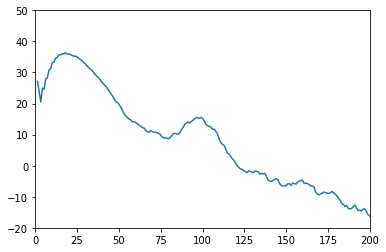

In [8]:
plt.plot(CF.r3D,CF.r3D*CF.r3D* CF.xi[:,0])
plt.ylim(-20,50)
plt.xlim(0,200)
plt.show()

In [9]:
r_tet1 = CF.r3D
xi_tet1 = CF.xi[:,0]

In [ ]:
# for ZA pts
pos  = np.float32(ZALoc_shifted)
delta = np.zeros((ngrid,ngrid,ngrid), dtype=np.float32)
MASL.MA(pos, delta, bigboxL, 'CIC')
delta /= np.mean(delta, dtype=np.float64);  delta -= 1.0 
CF  = PKL.Xi(delta, bigboxL, 'CIC', 0, nthreads)

r_tet1_ZApts = CF.r3D
xi_tet1_ZApts = CF.xi[:,0]

# 2. compute xi_tet4, xi_tet4_ZApts, xi_tet8, xi_tet8_ZApts, by simply xi()

In [5]:
bins = np.linspace(0.1,200,200)

In [6]:
mytetsize= 4
# select particles
xx=np.arange(Ndim)[0:Ndim:mytetsize]
Ndimtet = len(xx)
xg=np.meshgrid(xx,xx,xx,indexing='ij')
xidxs=np.ravel(xg[0])+xshift
yidxs=np.ravel(xg[1])+yshift
zidxs=np.ravel(xg[2])+zshift
selected3idx=np.array([xidxs,yidxs,zidxs]).transpose()
selected = selected3idx[:,0]*Ndim**2+selected3idx[:,1]*Ndim+selected3idx[:,2]

testposZA = ZALoc_shifted[selected]%(celllen*Ndim)
testpos = Loc_shifted[selected]%(celllen*Ndim)


# pair counting
X,Y,Z = (testpos[:,0],testpos[:,1],testpos[:,2])
print("computing xi",flush=True)
tstart = time()
xi_counts = xi(celllen*Ndim, nthreads, bins, X, Y, Z)
tend = time()
print("finished in %f sec"%(tend-tstart),flush=True)

r_tet4 = (xi_counts['rmax']+xi_counts['rmin'])/2
xi_tet4 = xi_counts['xi']

# pair counting
X,Y,Z = (testposZA[:,0],testposZA[:,1],testposZA[:,2])
print("computing xi in ZA",flush=True)
tstart = time()
xi_counts = xi(celllen*Ndim, nthreads, bins, X, Y, Z)
tend = time()
print("finished in %f sec"%(tend-tstart),flush=True)

r_tet4_ZApts = (xi_counts['rmax']+xi_counts['rmin'])/2
xi_tet4_ZApts = xi_counts['xi']

computing xi
finished in 28.855454 sec
computing xi in ZA
finished in 55.731557 sec


In [7]:
mytetsize= 8
# select particles
xx=np.arange(Ndim)[0:Ndim:mytetsize]
Ndimtet = len(xx)
xg=np.meshgrid(xx,xx,xx,indexing='ij')
xidxs=np.ravel(xg[0])+xshift
yidxs=np.ravel(xg[1])+yshift
zidxs=np.ravel(xg[2])+zshift
selected3idx=np.array([xidxs,yidxs,zidxs]).transpose()
selected = selected3idx[:,0]*Ndim**2+selected3idx[:,1]*Ndim+selected3idx[:,2]

testposZA = ZALoc_shifted[selected]%(celllen*Ndim)
testpos = Loc_shifted[selected]%(celllen*Ndim)


# pair counting
X,Y,Z = (testpos[:,0],testpos[:,1],testpos[:,2])
print("computing xi",flush=True)
tstart = time()
xi_counts = xi(celllen*Ndim, nthreads, bins, X, Y, Z)
tend = time()
print("finished in %f sec"%(tend-tstart),flush=True)

r_tet8 = (xi_counts['rmax']+xi_counts['rmin'])/2
xi_tet8 = xi_counts['xi']

# pair counting
X,Y,Z = (testposZA[:,0],testposZA[:,1],testposZA[:,2])
print("computing xi in ZA",flush=True)
tstart = time()
xi_counts = xi(celllen*Ndim, nthreads, bins, X, Y, Z)
tend = time()
print("finished in %f sec"%(tend-tstart),flush=True)

r_tet8_ZApts = (xi_counts['rmax']+xi_counts['rmin'])/2
xi_tet8_ZApts = xi_counts['xi']

computing xi
finished in 0.649889 sec
computing xi in ZA
finished in 0.916167 sec


In [8]:
xiCenRes = np.load(snapdir + "xiCenresampled_snap%03d_tet%d_%d%d%d.npy"%(4,4,0,0,0))
xiCenRes_ZApts = np.load(snapdir + "xiCenresampled_snap%03d_tet%d_%d%d%d_ZApts.npy"%(4,4,0,0,0))
xiRes = np.load(snapdir + "xiresampled_snap%03d_tet%d_%d%d%d_split%d.npy"%(4,8,0,0,0,5))
xiRes_ZApts = np.load(snapdir + "xiresampled_snap%03d_tet%d_%d%d%d_split%d_ZApts.npy"%(4,8,0,0,0,5))

xiall = np.load(snapdir + "xi_snap%03d_tet%d.npy"%(4,1))
xiall_ZApts = np.load(snapdir + "xi_snap%03d_tet%d_ZApts.npy"%(4,1))


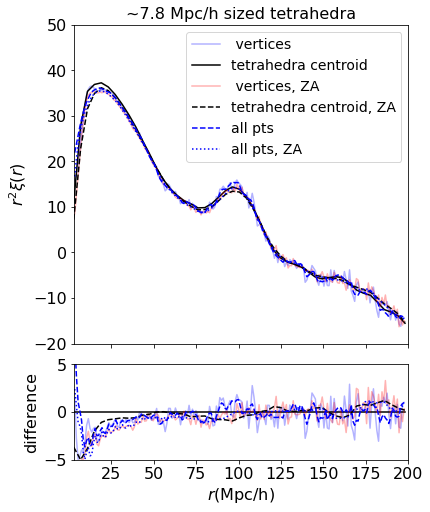

In [22]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0.1, 'height_ratios': [10, 3]})
fig.set_size_inches([6,8])

ru = 198
rl = 3


r = (xiCenRes['rmax']+xiCenRes['rmin'])/2
xiCenResintp = interp1d(r,xiCenRes['xi'])

msk = r_tet4 < ru
msk = msk *( r_tet4>rl )
rmsk = r_tet4[msk]
xi = xi_tet4[msk]
axs[0].plot(rmsk,xi*rmsk**2,'b'  ,label = ' vertices',alpha = 0.3)
axs[1].plot(rmsk,(xi-xiCenResintp(rmsk))*rmsk**2,'b',alpha = 0.3)

axs[0].plot(r,xiCenRes['xi']*r**2,'k'  ,label = 'tetrahedra centroid')
axs[1].plot(r,(xiCenRes['xi']-xiCenResintp(r))*r**2,'k')

msk = r_tet4_ZApts < ru
msk = msk *( r_tet4_ZApts>rl )
rmsk = r_tet4_ZApts[msk]
xi = xi_tet4_ZApts[msk]
axs[0].plot(rmsk,xi*rmsk**2,'r'  ,label = ' vertices, ZA',alpha = 0.3)
axs[1].plot(rmsk,(xi-xiCenResintp(rmsk))*rmsk**2,'r',alpha = 0.3)

axs[0].plot(r,xiCenRes_ZApts['xi']*r**2,'k--'  ,label = 'tetrahedra centroid, ZA')
axs[1].plot(r,(xiCenRes_ZApts['xi']-xiCenResintp(r))*r**2,'k--')


rall = (xiall['rmax']+xiall['rmin'])/2
msk = rall < ru
msk = msk *( rall>rl )
rmsk = rall[msk]
xi = xiall['xi'][msk]
axs[0].plot(rmsk,xi*rmsk**2,'b--'  ,label = 'all pts')
axs[1].plot(rmsk,(xi-xiCenResintp(rmsk))*rmsk**2,'b--')

xi = xiall_ZApts['xi'][msk]
axs[0].plot(rmsk,xi*rmsk**2,'b:'  ,label = 'all pts, ZA')
axs[1].plot(rmsk,(xi-xiCenResintp(rmsk))*rmsk**2,'b:')


axs[0].set_ylim(-20,50)
axs[1].set_ylim(-5,5)
axs[0].set_xlim(rl,200)
axs[0].set_ylabel('$ r^2 \\xi (r) $',fontsize=16)
axs[1].set_ylabel('difference',fontsize=16)
axs[1].set_xlabel('$r$(Mpc/h)',fontsize=16)
axs[0].tick_params(axis='y', labelsize=16)
axs[1].tick_params(axis='y', labelsize=16)
axs[1].tick_params(axis='x', labelsize=16)
axs[0].legend(fontsize=14)
axs[0].set_title("~7.8 Mpc/h sized tetrahedra",fontsize=16)
#plt.savefig('QuijoteCF_tet4.pdf',bbox_inches='tight')
plt.show()

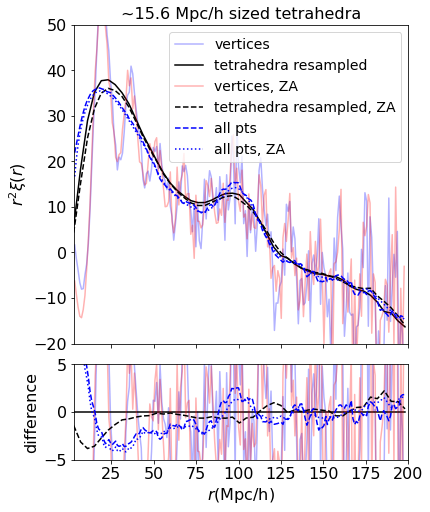

In [21]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0.1, 'height_ratios': [10, 3]})
fig.set_size_inches([6,8])

ru = 198
rl = 3


r = (xiRes['rmax']+xiRes['rmin'])/2
xiResintp = interp1d(r,xiRes['xi'])

msk = r_tet8 < ru
msk = msk *( r_tet8>rl )
rmsk = r_tet8[msk]
xi = xi_tet8[msk]
axs[0].plot(rmsk,xi*rmsk**2,'b'  ,label = 'vertices',alpha = 0.3)
axs[1].plot(rmsk,(xi-xiResintp(rmsk))*rmsk**2,'b',alpha = 0.3)

axs[0].plot(r,xiRes['xi']*r**2,'k'  ,label = 'tetrahedra resampled')
axs[1].plot(r,(xiRes['xi']-xiResintp(r))*r**2,'k')

msk = r_tet8_ZApts < ru
msk = msk *( r_tet8_ZApts>rl )
rmsk = r_tet8_ZApts[msk]
xi = xi_tet8_ZApts[msk]
axs[0].plot(rmsk,xi*rmsk**2,'r'  ,label = 'vertices, ZA', alpha = 0.3)
axs[1].plot(rmsk,(xi-xiResintp(rmsk))*rmsk**2,'r',alpha = 0.3)

axs[0].plot(r,xiRes_ZApts['xi']*r**2,'k--'  ,label = 'tetrahedra resampled, ZA')
axs[1].plot(r,(xiRes_ZApts['xi']-xiResintp(r))*r**2,'k--')


rall = (xiall['rmax']+xiall['rmin'])/2
msk = rall < ru
msk = msk *( rall>rl )
rmsk = rall[msk]
xi = xiall['xi'][msk]
axs[0].plot(rmsk,xi*rmsk**2,'b--'  ,label = 'all pts')
axs[1].plot(rmsk,(xi-xiResintp(rmsk))*rmsk**2,'b--')

xi = xiall_ZApts['xi'][msk]
axs[0].plot(rmsk,xi*rmsk**2,'b:'  ,label = 'all pts, ZA')
axs[1].plot(rmsk,(xi-xiResintp(rmsk))*rmsk**2,'b:')

axs[0].set_ylim(-20,50)
axs[1].set_ylim(-5,5)
axs[0].set_xlim(rl,200)
axs[0].set_ylabel('$ r^2 \\xi (r) $',fontsize=16)
axs[1].set_ylabel('difference',fontsize=16)
axs[1].set_xlabel('$r$(Mpc/h)',fontsize=16)
axs[0].tick_params(axis='y', labelsize=16)
axs[1].tick_params(axis='y', labelsize=16)
axs[1].tick_params(axis='x', labelsize=16)
axs[0].legend(fontsize=14)
axs[0].set_title("~15.6 Mpc/h sized tetrahedra",fontsize=16)
#plt.savefig('QuijoteCF_tet8.pdf',bbox_inches='tight')
plt.show()

# compare with xi suing all pts

In [13]:
((xiall['rmax']+xiall['rmin'])/2).shape

(199,)

In [14]:

r = (xiall['rmax']+xiall['rmin'])/2
xiallintp = interp1d(r,xiall['xi'])

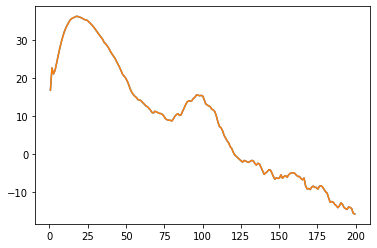

In [16]:
plt.plot(r,xiall['xi']*r**2)
plt.show()

In [ ]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0.1, 'height_ratios': [10, 3]})
fig.set_size_inches([6,8])

ru = 198
rl = 3


r = (xiall['rmax']+xiall['rmin'])/2
xiallintp = interp1d(r,xiall['xi'])

msk = r_tet4 < ru
msk = msk *( r_tet4>rl )
rmsk = r_tet4[msk]
xi = xi_tet4[msk]
axs[0].plot(rmsk,xi*rmsk**2,'b'  ,label = ' vertices',alpha = 0.3)
axs[1].plot(rmsk,(xi-xiCenResintp(rmsk))*rmsk**2,'b',alpha = 0.3)

axs[0].plot(r,xiCenRes['xi']*r**2,'k'  ,label = 'tetrahedra centroid')
axs[1].plot(r,(xiCenRes['xi']-xiCenResintp(r))*r**2,'k')

msk = r_tet4_ZApts < ru
msk = msk *( r_tet4_ZApts>rl )
rmsk = r_tet4_ZApts[msk]
xi = xi_tet4_ZApts[msk]
axs[0].plot(rmsk,xi*rmsk**2,'r'  ,label = ' vertices, ZA',alpha = 0.3)
axs[1].plot(rmsk,(xi-xiCenResintp(rmsk))*rmsk**2,'r',alpha = 0.3)

axs[0].plot(r,xiCenRes_ZApts['xi']*r**2,'k--'  ,label = 'tetrahedra centroid, ZA')
axs[1].plot(r,(xiCenRes_ZApts['xi']-xiCenResintp(r))*r**2,'k--')


axs[0].set_ylim(-20,50)
axs[1].set_ylim(-5,5)
axs[0].set_xlim(rl,200)
axs[0].set_ylabel('$ r^2 \\xi (r) $',fontsize=16)
axs[1].set_ylabel('difference',fontsize=16)
axs[1].set_xlabel('$r$(Mpc/h)',fontsize=16)
axs[0].tick_params(axis='y', labelsize=16)
axs[1].tick_params(axis='y', labelsize=16)
axs[1].tick_params(axis='x', labelsize=16)
axs[0].legend(fontsize=14)
axs[0].set_title("~7.8 Mpc/h sized tetrahedra",fontsize=16)
#plt.savefig('QuijoteCF_tet4.pdf',bbox_inches='tight')
plt.show()